## Instructions
### API Tokens and secrets.py
Add a file named secrets.py to the same directory as this notebook with a list of Instagram API Tokens, as follows:

        TOKENS = [
            '123',
            '456',
            '789'
        ]


In [1]:
import os
from datetime import datetime, date

from instagram.client import InstagramAPI
from instagram.bind import InstagramAPIError
import pymongo
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from mongo_helper import (
    CLIENT, 
    DB, 
    TRANS_COLLECTION,
    USER_PAIRS_COLLECTION,
    VENMO_INSTAGRAM_MATCHES
)
from instagram_helper import InstagramAPICycler, get_all_paginated_data
from secrets import TOKENS
from insta_query import query

API_CYCLER = InstagramAPICycler(TOKENS)
HEAVY_USER_THRESHOLD = 50
AFTER_CUTOFF_DATE = date(2015, 3, 1)
VENMO_DATE_FORMAT_STR = '%Y-%m-%dT%H:%M:%SZ'
GRAPHS_PATH = os.path.join(os.getcwd(), 'graphs')
if not os.path.exists(GRAPHS_PATH):
    os.mkdir(GRAPHS_PATH)

## Populate MongoDB with the Venmo-Instagram user matches

In [2]:
query(TOKENS, HEAVY_USER_THRESHOLD)

------FINDING VENMO USERS WITH >50 TARGET USERS------
Completed aggregate query of user_pairs collection. Completed in 24.266800 seconds.

Venmo user ibotta transacted with 1655 other users
Venmo user marakimb transacted with 234 other users
Venmo user laurengil transacted with 108 other users
Venmo user Ben-Delhoum transacted with 108 other users
Venmo user Ben-Delhoum transacted with 108 other users
Venmo user Nguyen-Vu transacted with 87 other users
Venmo user zacharydewitt transacted with 85 other users
Venmo user MoveLootInc transacted with 18 other users
Venmo user ShoutInc transacted with 77 other users
Venmo user Texas-Darlins transacted with 76 other users
Venmo user Indo-DVC transacted with 68 other users
Venmo user Jon-Zelin transacted with 64 other users
Venmo user Jennifer-Henderson-1 transacted with 63 other users
Venmo user Shayna-Fader transacted with 57 other users
Venmo user fwedeorange transacted with 57 other users
Venmo user ErikBurbulla transacted with 56 other us

## Find Venmo users paired with Instagram users in MongoDB

In [3]:
user_matches = [result for result in VENMO_INSTAGRAM_MATCHES.find()]
print 'Total Venmo-Instagram user matches: %d' % len(user_matches)

Total Venmo-Instagram user matches: 420


## Load the user's Venmo transactions from MongoDB
### Includes transactions where the user is either the "actor" (payer) or the "target" (payee)

In [4]:
def venmo_user_trans(user_id):
    pipeline = [
        {"$unwind": "$transactions"},
        {"$match": {"$or": [
            {"actor.id": user_id},
            {"transactions.target.id": user_id}
        ]}},
        {"$sort": {"created_time": 1}}
    ]

    return [r for r in TRANS_COLLECTION.aggregate(pipeline)]

In [5]:
def parse_venmo_datetime(datetime_str):
    return datetime.strptime(datetime_str, VENMO_DATE_FORMAT_STR)

In [6]:
def get_venmo_trans_datetimes(transactions):
    return [parse_venmo_datetime( t.get('created_time') ) for t in transactions]

def get_instagram_datetimes(media):
    return [m.created_time for m in media]

## Group Venmo and Instagram posts over time

In [7]:
def group_by_date(datetimes, min_date=None):
    results = {}
    for dt in datetimes:
        if min_date is None or dt.date() >= min_date:
            results[dt.date()] = results.setdefault(dt.date(), 0) + 1
    return results

def normalize_date_data(data_dict, all_dates):
    normalized = {}
    for date in all_dates:
        normalized[date] = data_dict.setdefault(date, 0)
    return normalized

## Prepare the data for the plots

In [8]:
def get_api_data(venmo_user, instagram_user):
    instagram_id = instagram_user.get('id')
    media = get_all_paginated_data(API_CYCLER.api, 'user_recent_media', user_id=instagram_id, count=100)

    print '%d Media fetched for Instagram user %s (%s)' % (len(media), instagram_user.get('username'), instagram_user.get('id'))
    
    venmo_id = venmo_user.get('id')
    venmo_trans = venmo_user_trans(venmo_id)    
    print '%d Transactions fetched for Venmo user %s (%s)' % (len(venmo_trans), venmo_user.get('username'), venmo_user.get('id'))
    
    return venmo_trans, media

def normalize_for_plot(trans, media):
    venmo_trans_datetimes = get_venmo_trans_datetimes(trans)
    instagram_datetimes = get_instagram_datetimes(media)
    
    # Group media and transactions activity across individual days
    venmo_date_data = group_by_date(venmo_trans_datetimes, AFTER_CUTOFF_DATE)
    instagram_date_data = group_by_date(instagram_datetimes, AFTER_CUTOFF_DATE)
    
    full_date_set = set(instagram_date_data.keys()).union(venmo_date_data.keys())
    venmo_date_data_norm = normalize_date_data(venmo_date_data, full_date_set)
    instagram_date_data_norm = normalize_date_data(instagram_date_data, full_date_set)
    
    x = venmo_date_data_norm.keys()
    venmo_y = [venmo_date_data_norm[date] for date in venmo_date_data_norm.keys()]
    instagram_y = [instagram_date_data_norm[date] for date in instagram_date_data_norm.keys()]
    
    return x, venmo_y, instagram_y

## Plot one user's Venmo and Instagram activity

In [9]:
width = 0.35
days = mdates.DayLocator()
weeks = mdates.WeekdayLocator()
yearsFmt = mdates.DateFormatter('%Y')
date_fmt = mdates.DateFormatter('%d %b %Y')

def plot_user_data(x, venmo_y, instagram_y, venmo_user, instagram_user, fig_num):
    figure, ax = plt.subplots(figsize=(18, 4), num=fig_num)
    p1 = ax.bar(mdates.date2num(x), instagram_y, color='#ED913D', width=width, linewidth=0)
    p2 = ax.bar(mdates.date2num(x), venmo_y, color='#78b653', width=width, linewidth=0, bottom=instagram_y)
    
    # Formatting
    ax.xaxis.set_major_locator(weeks)
    ax.xaxis.set_minor_locator(days)
    ax.xaxis.set_major_formatter(date_fmt)
    ax.legend( (p1[0], p2[0]), ('Instagram', 'Venmo') )
    ax.set_ylabel('Activity')
    ax.set_xlabel('Dates')

    title_str = 'Venmo user %s (%s) | Instagram user %s (%s)' % (
        venmo_user.get('username'), venmo_user.get('id'),
        instagram_user.get('username'), instagram_user.get('id'),
    )
    ax.set_title(title_str)
    filename = '%s.png' % venmo_user.get('username')
    plt.savefig(os.path.join(GRAPHS_PATH, filename))
    plt.show()

## Main loop

77 Media fetched for Instagram user ibotta (1235351878)
2711 Transactions fetched for Venmo user ibotta (820531)


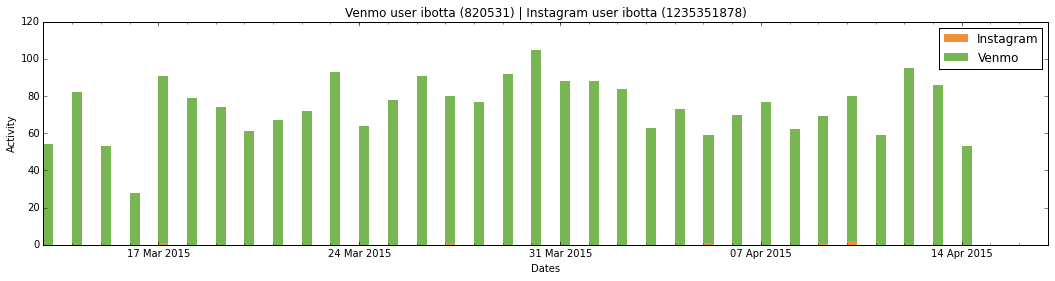

ERROR: Instagram user alliekranick -- 10676783 is set to private.
277 Media fetched for Instagram user fwedeorange (22924935)
231 Transactions fetched for Venmo user fwedeorange (1435640)


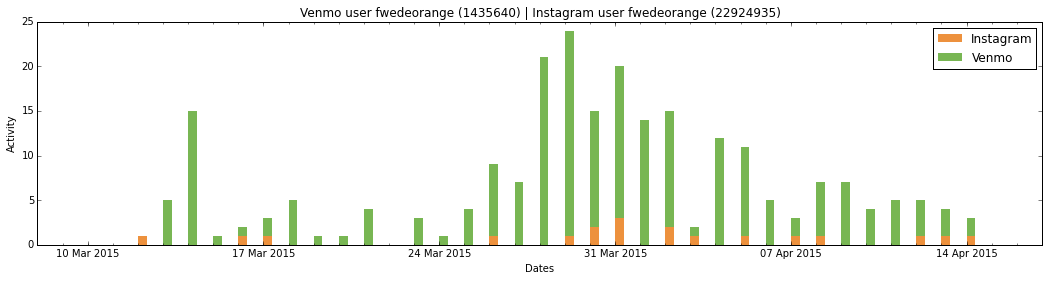

ERROR: Instagram user adedinata706 -- 626233630 is set to private.
141 Media fetched for Instagram user pdoryp (221265527)
5 Transactions fetched for Venmo user dorothyp (1450661)


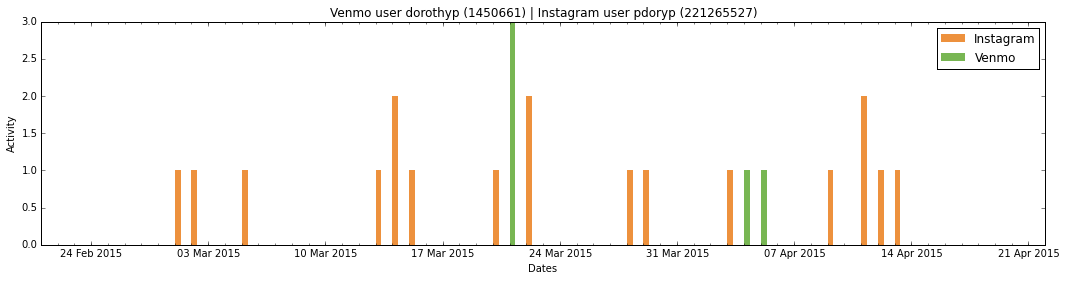

ERROR: Instagram user shirleyngg -- 238884066 is set to private.
12 Media fetched for Instagram user nathanwlee (210028842)


KeyboardInterrupt: 

In [10]:
for i, user_pair in enumerate(user_matches):
    instagram_user = user_pair.get('instagram')
    venmo_user = user_pair.get('venmo')
    
    try:
        venmo_trans, instagram_media = get_api_data(venmo_user, instagram_user)
    except InstagramAPIError as e:
        if (e.status_code == 400):
            print "ERROR: Instagram user %s -- %s is set to private." % (instagram_user.get('username'), instagram_user.get('id'))
        continue
    x, venmo_y, instagram_y = normalize_for_plot(venmo_trans, instagram_media)
    plot_user_data(x, venmo_y, instagram_y, venmo_user, instagram_user, i)
    
